In [ ]:
!pip cache purge
!pip install nltk
!pip install torch
!pip install gensim
!pip uninstall nltk
!pip install nltk


In [4]:
'''
CSCI 5832 Assignment 3
Spring 2025
Use this code as a starting point or reference for the data preprocessing portion 
of your assignment.
'''

import pandas as pd
# Load the Rotten Tomatoes polarity dataset
def load_rt_dataset():
    reviews = []
    for sentiment in ['pos', 'neg']:
        path = f'rt-polarity.{sentiment}'
        file = open(path)
        for line in file.readlines():
            review = line.strip()
            reviews.append({'review': review, 'sentiment': sentiment})
    return pd.DataFrame(reviews)

reviews = load_rt_dataset()
print(reviews.head())

# Tokenization and cleaning
import re
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text: str) -> list:
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, digits, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token]
    return tokens

# Preprocess all documents
preprocessed_documents = reviews['review'].apply(preprocess)
print(f'Number of preprocessed documents: {len(preprocessed_documents)}')
print(preprocessed_documents.head())

# Make a token2index dictionary and a index2token dictionary and convert the documents to sequences of indices
token2index = {}
index2token = {}
index = 1 # reserve 0 for padding
for document in preprocessed_documents:
    for token in document:
        if token not in token2index:  # Ensure each token is mapped only once
            token2index[token] = index
            index2token[index] = token
            index += 1

token2index['[PAD]'] = 0
index2token[0] = '[PAD]'

print(f'Number of unique tokens: {len(token2index)}')

# Convert the dataset into sequences of indices
def document_to_sequence(document : str) -> list:
    return [token2index[token] for token in document]

sequences = preprocessed_documents.apply(document_to_sequence)
print(sequences.head()) # should now be a list of indices

# Truncate the sequences
def pad_sequence(sequence: list, max_length: int, padding_token: int = 0) -> list:
    # your code here
    if len(sequence) > max_length:
        return sequence[:max_length]  # Truncate
    return sequence + [padding_token] * (max_length - len(sequence))
    

# Maximum sequence length
max_length = 40

# Truncate the sequences
truncated_sequences = sequences.apply(lambda x: pad_sequence(x, max_length))

print(truncated_sequences.head())

# Finally, convert the sequences to tensors and create dataloaders 
# for training, validation, and testing
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

# Split the dataset into training and testing sets
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(truncated_sequences, reviews['sentiment'], test_size=0.2, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_test_and_val, y_test_and_val, test_size=0.5, random_state=42)

# Encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.tolist())
y_val = label_encoder.transform(y_val.tolist())
y_test = label_encoder.transform(y_test.tolist())

# Convert the vectorized reviews to numpy arrays
X_train = torch.tensor(X_train.tolist())
X_val = torch.tensor(X_val.tolist())
X_test = torch.tensor(X_test.tolist())
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)

# Define the dataset class
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

# Define the dataloader
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data))

# check the first sequence with index2token
print([index2token[i.item()] for i in train_data.tensors[0][0]])

                                              review sentiment
0  the rock is destined to be the 21st century's ...       pos
1  the gorgeously elaborate continuation of " the...       pos
2                     effective but too-tepid biopic       pos
3  if you sometimes like to go to the movies to h...       pos
4  emerges as something rare , an issue movie tha...       pos


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of preprocessed documents: 10662
0    [the, rock, is, destined, to, be, the, st, cen...
1    [the, gorgeously, elaborate, continuation, of,...
2                   [effective, but, tootepid, biopic]
3    [if, you, sometimes, like, to, go, to, the, mo...
4    [emerges, a, something, rare, an, issue, movie...
Name: review, dtype: object
Number of unique tokens: 18317
0    [1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13,...
1    [1, 29, 30, 31, 32, 1, 33, 32, 1, 34, 35, 3, 3...
2                                     [53, 54, 55, 56]
3    [57, 58, 59, 60, 5, 61, 5, 1, 62, 5, 63, 64, 6...
4    [69, 16, 70, 71, 72, 73, 62, 74, 36, 75, 11, 7...
Name: review, dtype: object
0    [1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13,...
1    [1, 29, 30, 31, 32, 1, 33, 32, 1, 34, 35, 3, 3...
2    [53, 54, 55, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3    [57, 58, 59, 60, 5, 61, 5, 1, 62, 5, 63, 64, 6...
4    [69, 16, 70, 71, 72, 73, 62, 74, 36, 75, 11, 7...
Name: review, dtype: object
['not', 'everything'

In [47]:
'''
CSCI 5832 Assignment 3
Spring 2025
Use this code as a starting point or reference for the neural network design
and training portion of your assignment.
'''

# FF net with an nn.Embedding layer

import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, num_embeddings: int, embedding_dim: int, 
                 padding_idx: int = 0, pretrained_embeddings: torch.Tensor = None, freeze_embeddings: bool = False):
        super(Net, self).__init__()
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=padding_idx, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=padding_idx)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1) # take the mean of the embeddings
        # finish the code for the forward pass
        x = self.linear1(x)  # Shape: (batch_size, hidden_size)
        x = self.activation(x)
        x = self.linear2(x)  # Shape: (batch_size, output_size)
        x = self.sigmoid(x)  # Shape: (batch_size, output_size) (Binary classification)
        return x


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
#################### Training Loop ####################

# Hyperparameters that worked for TA on a CPU:
d = 50
h = 50
batch_size = 16
num_epochs = 10
learning_rate = 0.001

# Initialize the model
model = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=d,
    padding_idx=0
)

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopper = EarlyStopper(3,0.01)

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for i, (input_, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Clear previous gradients
        
        input_ = input_.to(torch.long)  # Ensure input is of type LongTensor for embedding lookup
        target = target.to(torch.float).view(-1, 1)  # Ensure target is float for BCELoss

        output = model(input_)  # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        
        train_losses.append(loss.item())

    # Compute average training loss
    avg_train_loss = sum(train_losses) / len(train_losses)

    # Validation phase
    model.eval()
    val_losses = []
    with torch.no_grad():
        for input_, target in val_loader:
            input_ = input_.to(torch.long)
            target = target.to(torch.float).view(-1, 1)

            output = model(input_)
            val_loss = criterion(output, target)
            val_losses.append(val_loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Check early stopping
    if early_stopper.early_stop(avg_val_loss):
        break

    # Print losses
    print(f"Epoch {epoch+1}/{num_epochs}")
    # print(f"Training loss: {avg_train_loss:.4f}")
    # print(f"Validation loss: {avg_val_loss:.4f}")

    print('training loss: %.4f' % loss.item()) # Please print the training and validation loss to ensure 
                                               # you're meeting the criteria specified in the writeup
    print('validation loss: %.4f' % val_loss)


#################### Evaluation ####################

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model
for batch in test_loader:
    test_inputs, test_targets = batch
with torch.no_grad():
    test_outputs = model(test_inputs)

predictions = test_outputs.view(-1)
predictions = torch.tensor([1 if x >= 0.5 else 0 for x in predictions])
print(f'accuracy: {accuracy_score(test_targets, predictions)}')
print(f'precision: {precision_score(test_targets, predictions)}')
print(f'recall: {recall_score(test_targets, predictions)}')
print(f'f1: {f1_score(test_targets, predictions)}')





Epoch 1/10
training loss: 0.5541
validation loss: 0.6766
Epoch 2/10
training loss: 0.3328
validation loss: 0.5794
Epoch 3/10
training loss: 0.1476
validation loss: 0.4562
Epoch 4/10
training loss: 0.0548
validation loss: 0.3311
Epoch 5/10
training loss: 0.0209
validation loss: 0.2346
accuracy: 0.7448405253283302
precision: 0.7191413237924866
recall: 0.7775628626692457
f1: 0.7472118959107806


In [17]:
################## Getting GloVe embeddings ##################

import gensim.downloader as api
embedding_dim = d
word_vectors = api.load(f"glove-wiki-gigaword-{embedding_dim}")

# Create the embedding matrix with the pretrained embeddings and the token2index dictionary
embedding_matrix = torch.zeros(len(token2index), embedding_dim)
for token, index in token2index.items():
    if token in word_vectors:
        embedding_matrix[index] = torch.tensor(word_vectors[token])

# Convert embedding_matrix to float32 tensor
embedding_matrix = embedding_matrix.to(torch.float32)

# Initialize model with pre-trained embeddings
model = Net(
    input_size=embedding_dim,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=d,
    padding_idx=0,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False  # Set to False if you want to fine-tune
)

import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score

# Hyperparameters
d = 50
h = 50
batch_size = 16
num_epochs = 10
learning_rate = 0.001

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopper = EarlyStopper(3,0.01)

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for i, (input_, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Clear previous gradients
        
        input_ = input_.to(torch.long)  # Ensure input is of type LongTensor for embedding lookup
        target = target.to(torch.float).view(-1, 1)  # Ensure target is float for BCELoss

        output = model(input_)  # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        
        train_losses.append(loss.item())

    # Compute average training loss
    avg_train_loss = sum(train_losses) / len(train_losses)

    # Validation phase
    model.eval()
    val_losses = []
    with torch.no_grad():
        for input_, target in val_loader:
            input_ = input_.to(torch.long)
            target = target.to(torch.float).view(-1, 1)

            output = model(input_)
            val_loss = criterion(output, target)
            val_losses.append(val_loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Check early stopping
    if early_stopper.early_stop(avg_val_loss):
        break

    # Print losses
    print(f"Epoch {epoch+1}/{num_epochs}")
    # print(f"Training loss: {avg_train_loss:.4f}")
    # print(f"Validation loss: {avg_val_loss:.4f}")

    print('training loss: %.4f' % loss.item()) # Please print the training and validation loss to ensure 
                                               # you're meeting the criteria specified in the writeup
    print('validation loss: %.4f' % val_loss)
    
for batch in test_loader:
    test_inputs, test_targets = batch
with torch.no_grad():
    test_outputs = model(test_inputs)

predictions = test_outputs.view(-1)
predictions = torch.tensor([1 if x >= 0.5 else 0 for x in predictions])
print(f'accuracy: {accuracy_score(test_targets, predictions)}')
print(f'precision: {precision_score(test_targets, predictions)}')
print(f'recall: {recall_score(test_targets, predictions)}')
print(f'f1: {f1_score(test_targets, predictions)}')


Epoch 1/10
training loss: 0.7493
validation loss: 0.4194
Epoch 2/10
training loss: 0.5763
validation loss: 0.2169
Epoch 3/10
training loss: 0.1800
validation loss: 0.1465
Epoch 4/10
training loss: 0.0465
validation loss: 0.1061
Epoch 5/10
training loss: 0.0132
validation loss: 0.0775
accuracy: 0.7654784240150094
precision: 0.7675350701402806
recall: 0.7408123791102514
f1: 0.7539370078740159


In [ ]:
import torch.nn.functional as F
def k_nearest_neighbors(embeddings, token2index, token, k: int = 5):
    # your code here
    if token not in token2index:
        raise ValueError(f"Token '{token}' not found in vocabulary.")

    # Get the index of the token
    token_idx = token2index[token]

    # Get the embedding of the target token
    token_embedding = embeddings[token_idx].unsqueeze(0)  # Shape: (1, embedding_dim)

    # Compute cosine similarity between the target token and all embeddings
    similarities = F.cosine_similarity(token_embedding, embeddings, dim=1)  # Shape: (num_tokens,)

    # Get the top-k indices (including the token itself)
    top_k_indices = similarities.argsort(descending=True)[:k]

    # Convert indices back to tokens
    index2token = {idx: tok for tok, idx in token2index.items()}
    nearest_tokens = [index2token[idx.item()] for idx in top_k_indices]

    return nearest_tokens

# Find the 10 nearest neighbors for "good"
nearest_neighbors = k_nearest_neighbors(embedding_matrix, token2index, 'good', k=10)
print(nearest_neighbors)


In [22]:
def plot_embeddings_3d(embeddings, num_embeddings_to_plot: int = 250):

    # Don't plot stopwords
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    non_stop_words = [token for token in list(token2index.keys()) if token not in stop_words]
    indices_to_take = [token2index[token] for token in non_stop_words[:num_embeddings_to_plot]]
    subset_of_embeddings = embeddings[indices_to_take, :]

    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    # PCA
    pca = PCA(n_components=3)
    components = pca.fit_transform(subset_of_embeddings)

    # Create a 3D scatter plot of the projection
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(components[:, 0], components[:, 1], components[:, 2], s=10)

    for i, index_in_dict in enumerate(indices_to_take):
        token = index2token[index_in_dict]
        ax.text(components[i, 0], components[i, 1], components[i, 2], token)
    plt.show()

def plot_embeddings_tsne(embeddings, num_embeddings_to_plot: int = 2000, pca_n_components: int = 50):
    # Don't plot stopwords
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    non_stop_words = [token for token in list(token2index.keys()) if token not in stop_words]
    indices_to_take = [token2index[token] for token in non_stop_words[:num_embeddings_to_plot]]
    subset_of_embeddings = embeddings[indices_to_take, :]

    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    random_state = 42
    vocab = [index2token[index] for index in indices_to_take]
    colors = ['black' for i in vocab]
    # reduction with PCA
    pca = PCA(n_components=pca_n_components, random_state=random_state)
    X = pca.fit_transform(subset_of_embeddings)
    # t-SNE:
    tsne = TSNE(
        n_components=2,
        init='random',
        learning_rate='auto',
        random_state=random_state)
    tsnemat = tsne.fit_transform(X)
    # Plot values:
    xvals = tsnemat[: , 0]
    yvals = tsnemat[: , 1]
    # Plotting:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,30))
    ax.plot(xvals, yvals, marker='', linestyle='')
    # Text labels:
    for word, x, y, color in zip(vocab, xvals, yvals, colors):
        try:
            ax.annotate(word, (x, y), fontsize=8, color=color)
        except UnicodeDecodeError:
            pass
    plt.axis('off')
    plt.show()

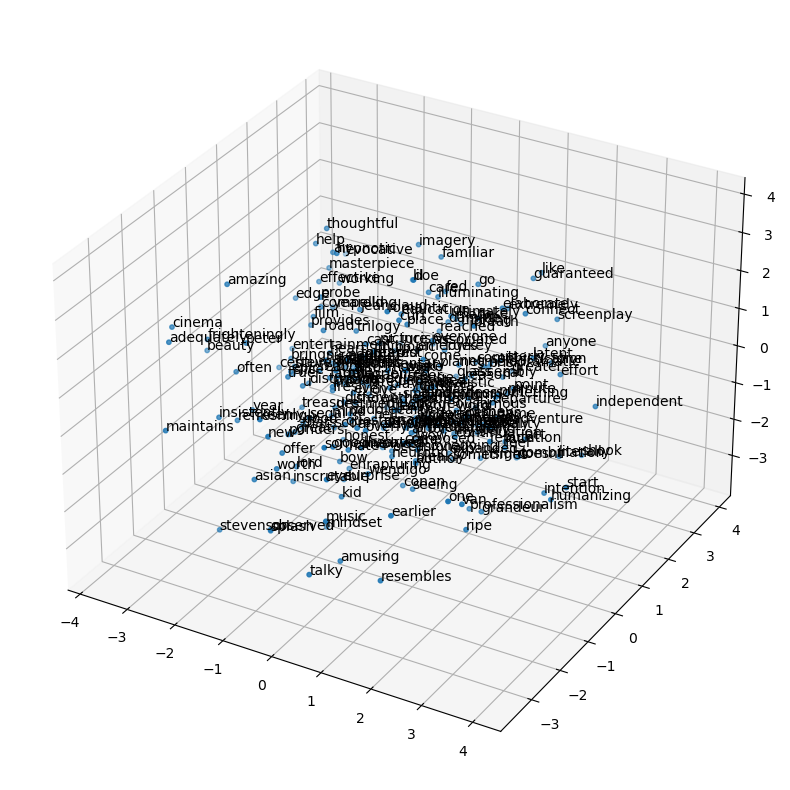

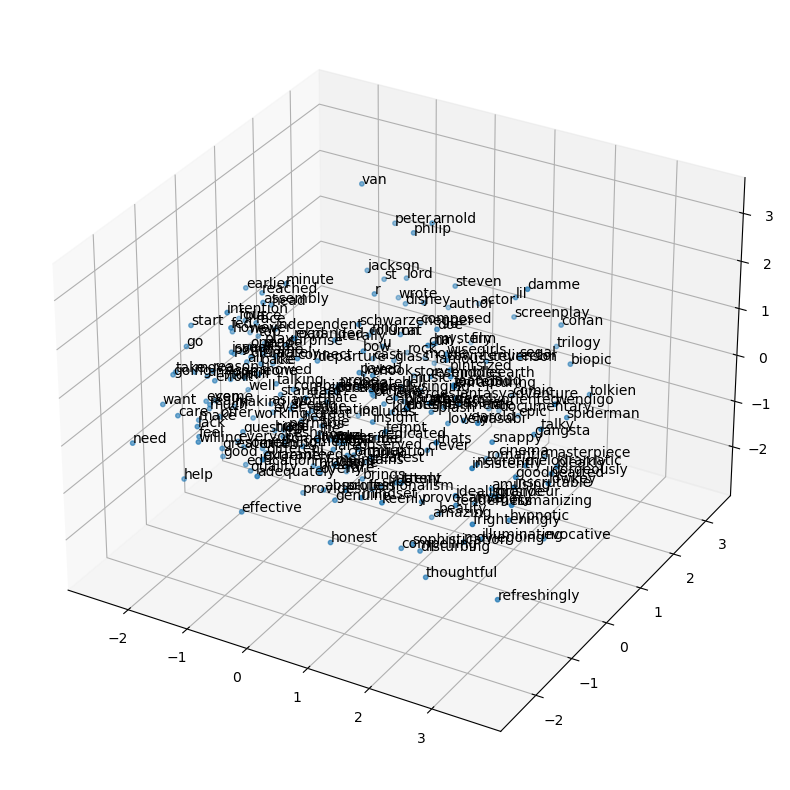

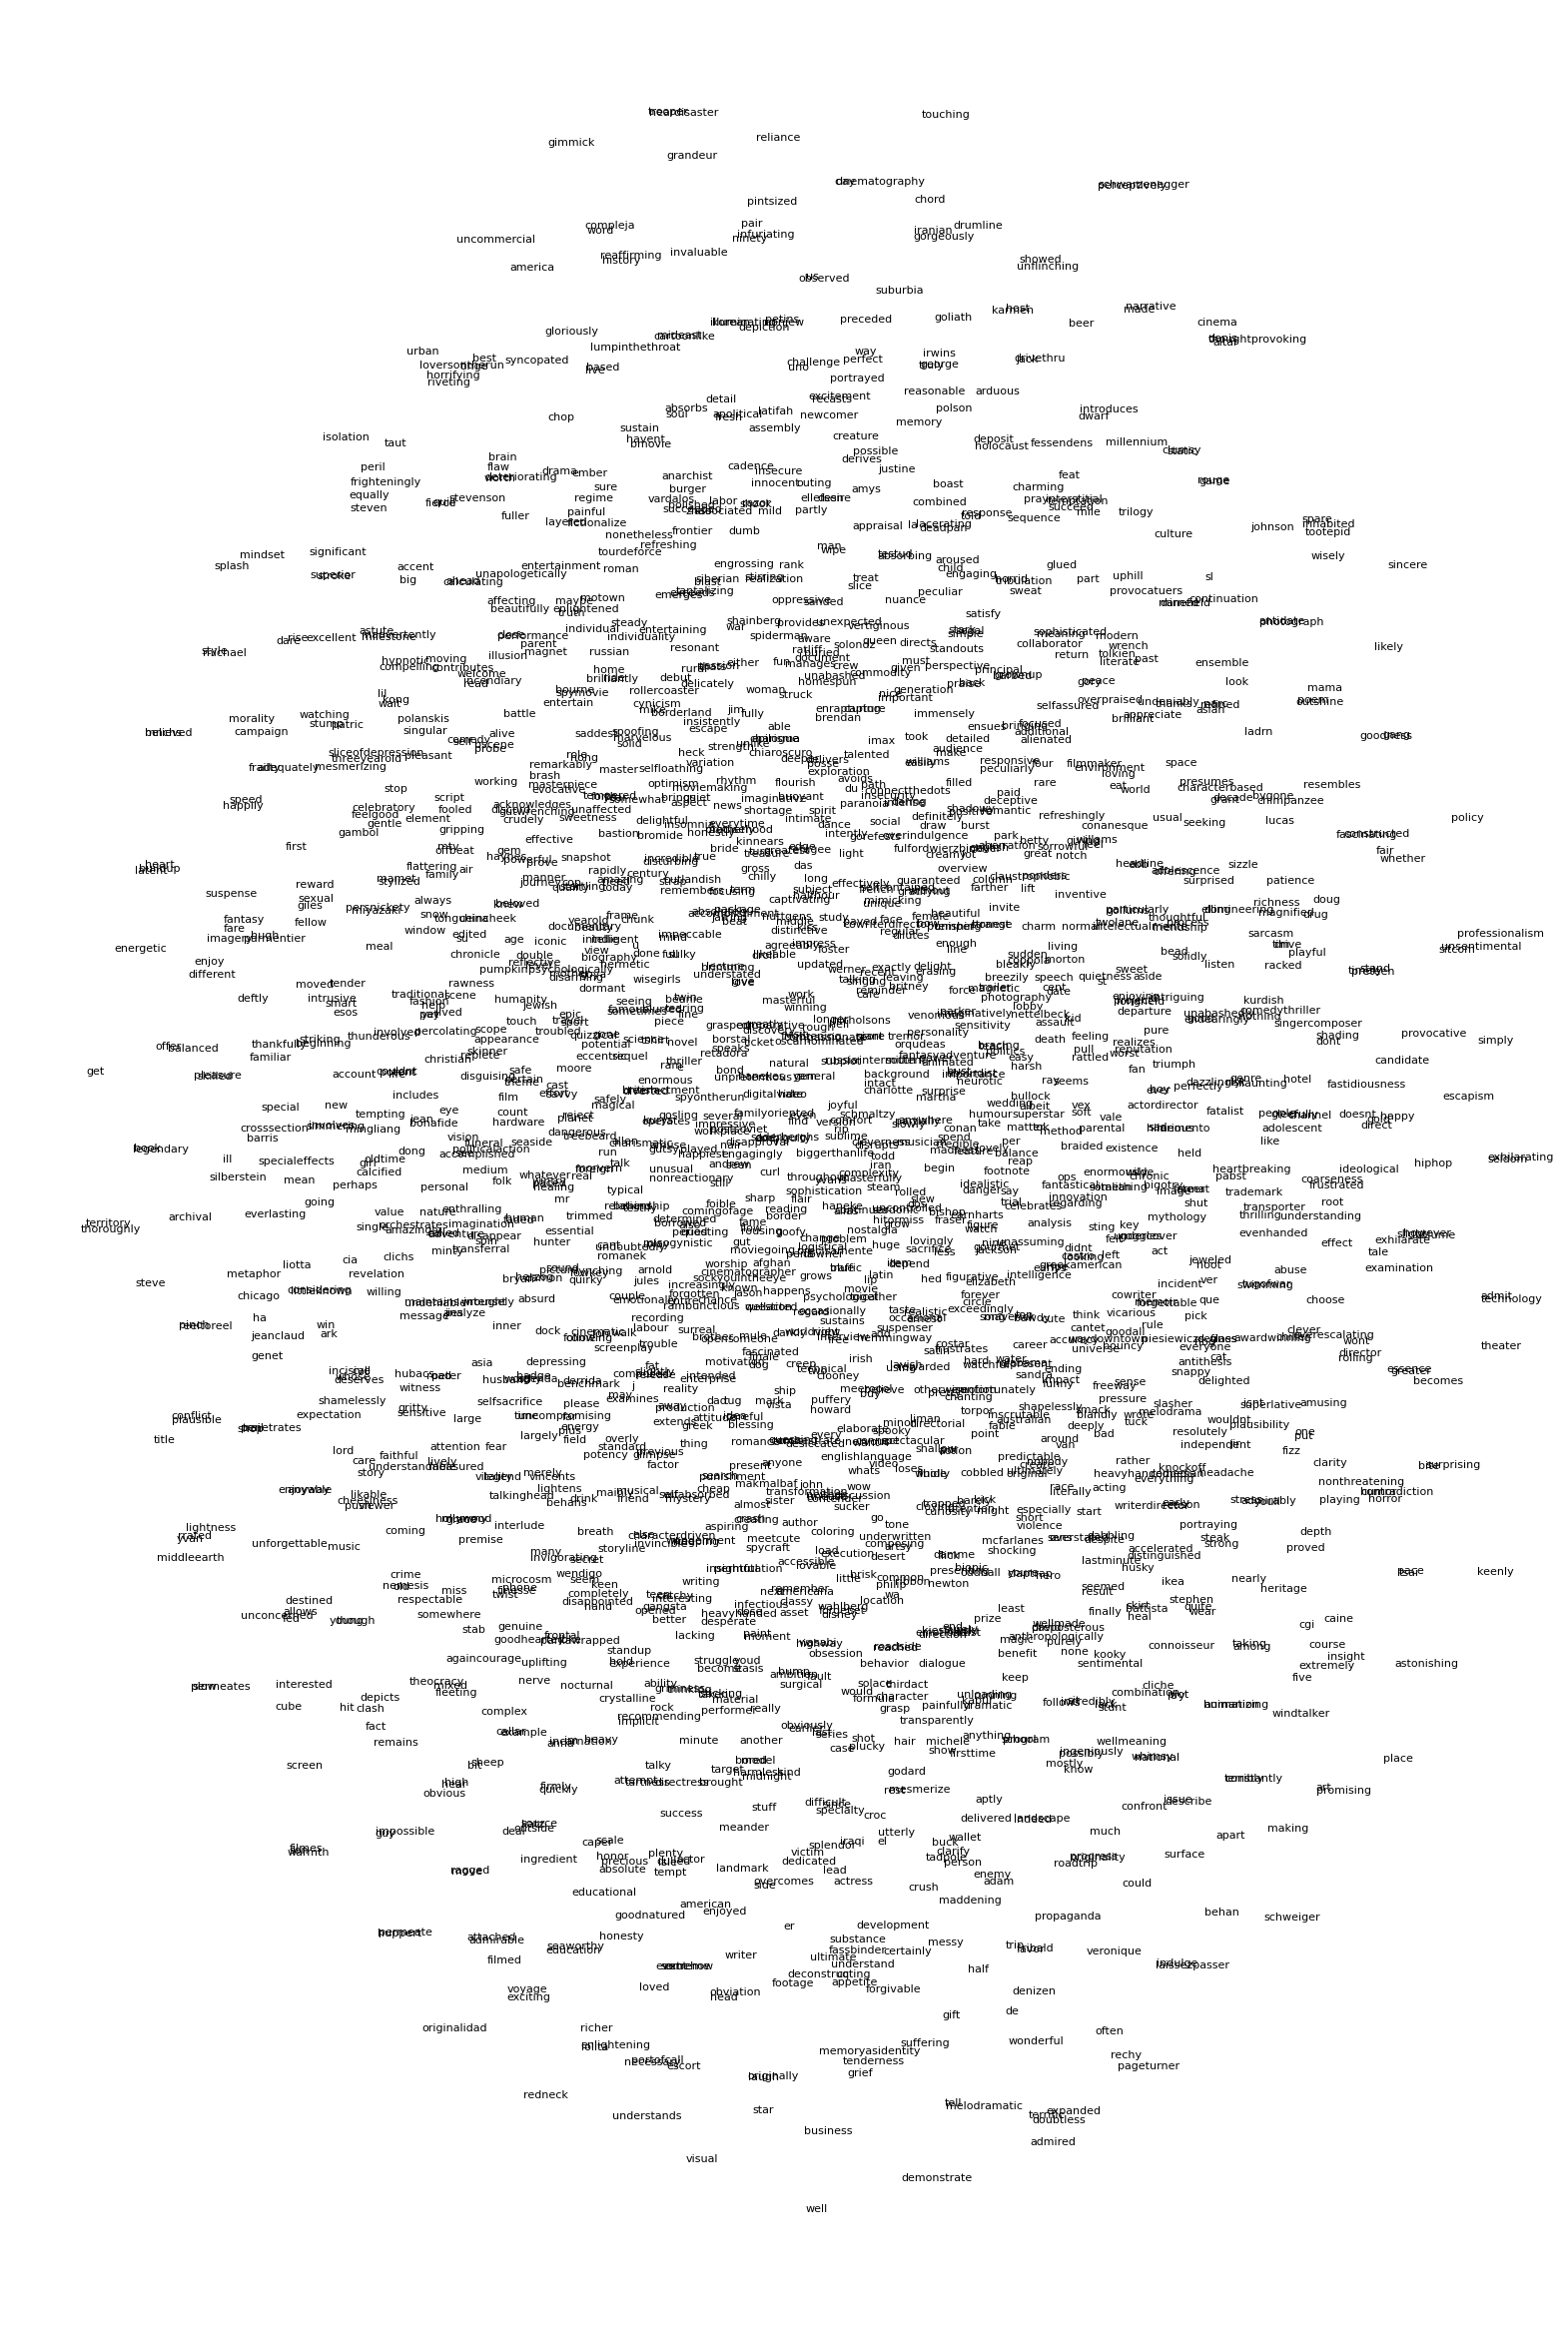

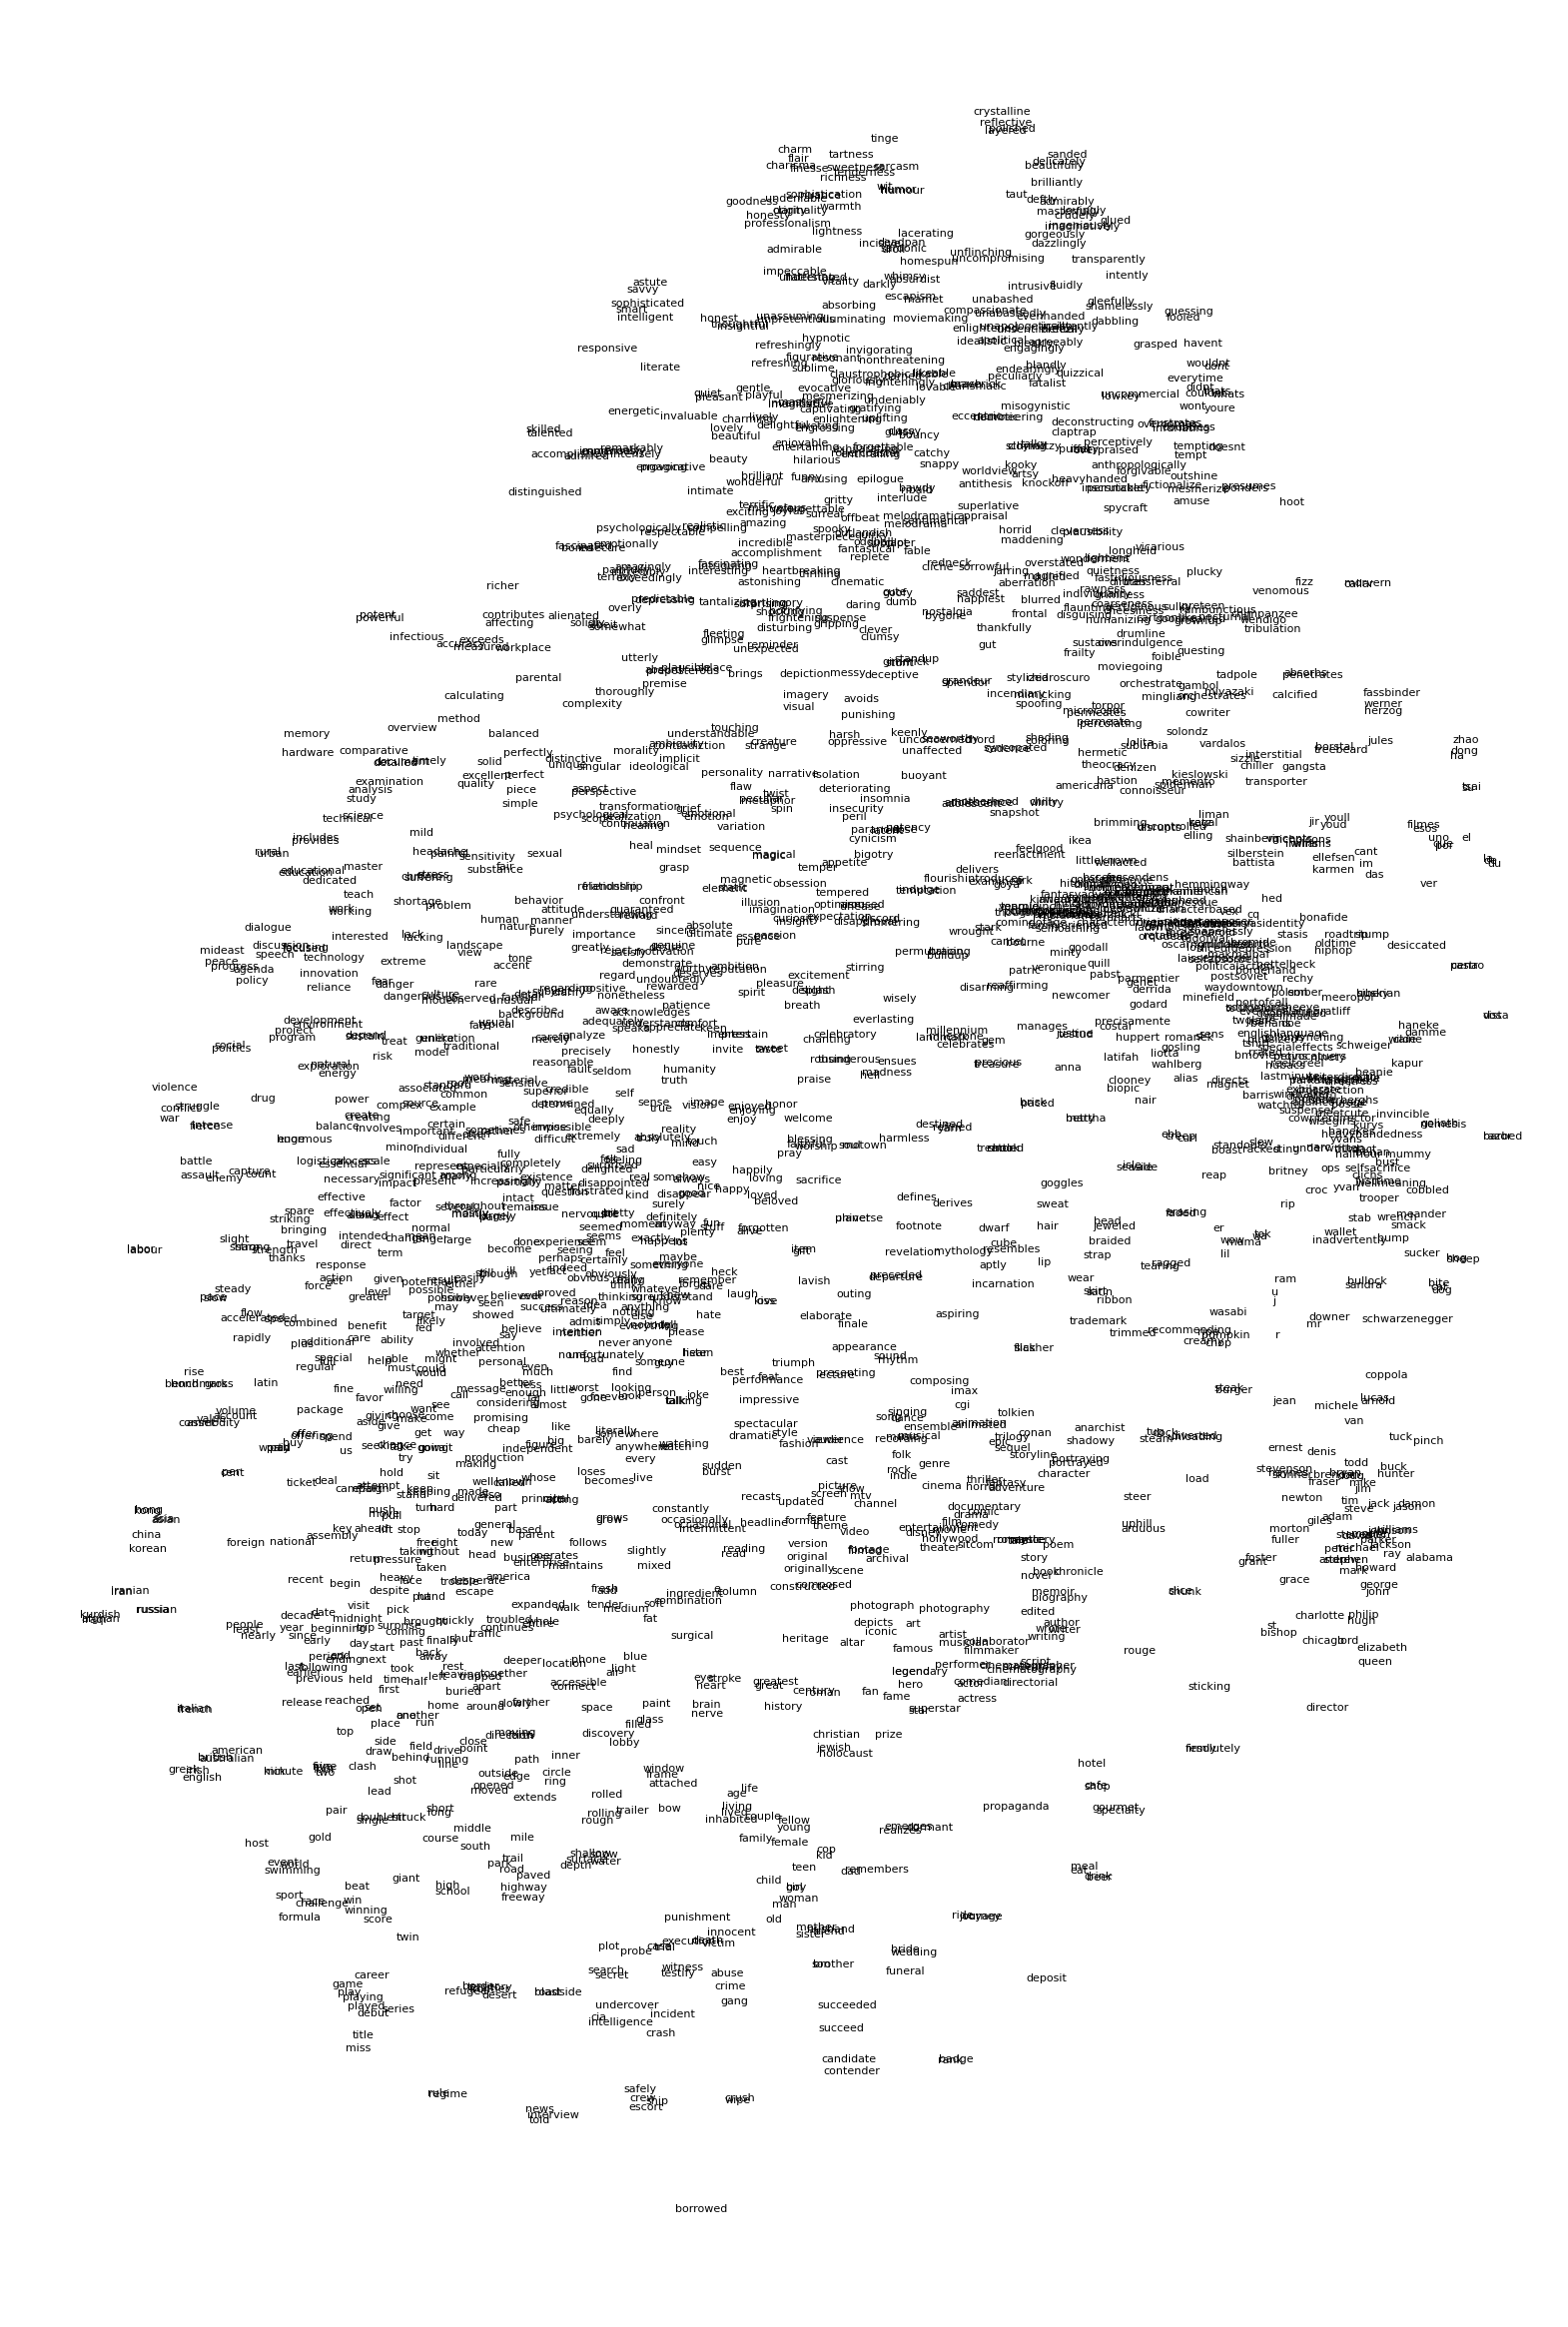

In [24]:
# Plot embeddings from the trained model
plot_embeddings_3d(model.embedding.weight.detach().cpu().numpy())

# Plot GloVe embeddings
plot_embeddings_3d(embedding_matrix.numpy())

# Plot trained embeddings using t-SNE
plot_embeddings_tsne(model.embedding.weight.detach().cpu().numpy())

# Plot GloVe embeddings using t-SNE
plot_embeddings_tsne(embedding_matrix.numpy())


In [41]:

def train_and_validate_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, early_stop_patience=3, delta=0.01):
    # Initialize criterion, optimizer, and early stopper
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    early_stopper = EarlyStopper(patience=early_stop_patience)

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        # Training phase
        for i, (input_, target) in enumerate(train_loader):
            optimizer.zero_grad()  # Clear previous gradients
            
            input_ = input_.to(torch.long)  # Ensure input is of type LongTensor for embedding lookup
            target = target.to(torch.float).view(-1, 1)  # Ensure target is float for BCELoss

            output = model(input_)  # Forward pass
            loss = criterion(output, target)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            
            train_losses.append(loss.item())

        # Compute average training loss for the epoch
        avg_train_loss = sum(train_losses) / len(train_losses)

        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for input_, target in val_loader:
                input_ = input_.to(torch.long)
                target = target.to(torch.float).view(-1, 1)

                output = model(input_)
                val_loss = criterion(output, target)
                val_losses.append(val_loss.item())

        # Compute average validation loss
        avg_val_loss = sum(val_losses) / len(val_losses)

        # Early stopping check
        if early_stopper.early_stop(avg_val_loss):
            print(f"Early stopping at epoch {epoch+1}. Validation loss did not improve enough.")
            break

        # Print losses for the current epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training loss: {avg_train_loss:.4f}")
        print(f"Validation loss: {avg_val_loss:.4f}")
    return

# Example usage:
# Assuming the model, train_loader, and val_loader are already defined
# train_and_validate_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)


def run_experiments():
    embedding_dims = [50, 100, 200]
    batch_sizes = [16, 32, 64]
    num_epochs_list = [5, 10, 20]
    hidden_size = 128  # Set based on your architecture
    output_size = 1    # Assuming binary classification (change if needed)
    padding_idx = 0

    results = []

    for d in embedding_dims:
        for batch_size in batch_sizes:
            for num_epochs in num_epochs_list:
                for use_pretrained in [False, True]:
                    for freeze in [False, True] if use_pretrained else [False]:  # Freezing only applies to pre-trained
                        print(f"Running: d={d}, batch_size={batch_size}, num_epochs={num_epochs}, use_pretrained={use_pretrained}, freeze={freeze}")

                        # Get pretrained embeddings if required
                        pretrained_embeddings = embedding_matrix if use_pretrained else None

                        # Initialize the model
                        model = Net(
                            input_size=d, 
                            output_size=output_size, 
                            hidden_size=hidden_size, 
                            num_embeddings=len(token2index), 
                            embedding_dim=d, 
                            padding_idx=padding_idx, 
                            pretrained_embeddings=pretrained_embeddings, 
                            freeze_embeddings=freeze
                        )

                        # Train and evaluate
                        acc = train_and_validate_model(
                            model, 
                            train_loader,  # Using existing train_loader
                            val_loader,    # Using existing val_loader
                            num_epochs=num_epochs,
                            learning_rate=0.001,  # You can adjust this if needed
                            early_stop_patience=3, 
                        )

                        # Store results
                        results.append({
                            "embedding_dim": d,
                            "batch_size": batch_size,
                            "num_epochs": num_epochs,
                            "use_pretrained": use_pretrained,
                            "freeze": freeze,
                            "accuracy": acc  # Store accuracy from the training loop
                        })

    print("Experiments complete!")
    return results


results = run_experiments()

# Save results
df = pd.DataFrame(results)
df.to_csv("experiment_results.csv", index=False)


Running: d=50, batch_size=16, num_epochs=5, use_pretrained=False, freeze=False
Epoch 1/5
Training loss: 0.6731
Validation loss: 0.6514
Epoch 2/5
Training loss: 0.5691
Validation loss: 0.5993
Epoch 3/5
Training loss: 0.4508
Validation loss: 0.5843
Epoch 4/5
Training loss: 0.3493
Validation loss: 0.6003
Epoch 5/5
Training loss: 0.2671
Validation loss: 0.6416
Running: d=50, batch_size=16, num_epochs=5, use_pretrained=True, freeze=False
Epoch 1/5
Training loss: 0.2141
Validation loss: 0.7432
Epoch 2/5
Training loss: 0.0379
Validation loss: 0.9732
Epoch 3/5
Training loss: 0.0247
Validation loss: 1.2087
Early stopping at epoch 4. Validation loss did not improve enough.
Running: d=50, batch_size=16, num_epochs=5, use_pretrained=True, freeze=True
Epoch 1/5
Training loss: 0.1868
Validation loss: 0.7780
Epoch 2/5
Training loss: 0.0215
Validation loss: 1.0439
Epoch 3/5
Training loss: 0.0146
Validation loss: 1.2890
Early stopping at epoch 4. Validation loss did not improve enough.
Running: d=50, b

KeyboardInterrupt: 

In [42]:
def glove_nearest_neighbors(word_vectors, token, k=10):
    if token not in word_vectors:
        raise ValueError(f"Token '{token}' not found in GloVe vocabulary.")
    return [word for word, _ in word_vectors.most_similar(token, topn=k)]

def compare_embeddings(words, trained_embeddings, token2index, word_vectors):
    for word in words:
        print(f"\nWord: {word}")

        # Trained model neighbors
        try:
            nearest_trained = k_nearest_neighbors(trained_embeddings, token2index, word, k=10)
            print(f"Trained Embeddings Nearest Neighbors: {nearest_trained}")
        except ValueError:
            print("Word not found in trained vocabulary.")

        # GloVe neighbors
        try:
            nearest_glove = glove_nearest_neighbors(word_vectors, word, k=10)
            print(f"GloVe Nearest Neighbors: {nearest_glove}")
        except ValueError:
            print("Word not found in GloVe vocabulary.")

# Load GloVe embeddings
embedding_dim = 50  # Change this if you used a different dimension
word_vectors = api.load(f"glove-wiki-gigaword-{embedding_dim}")

# Words to compare
words_to_compare = ["good", "bad", "film", "actor", "story"]

# Perform comparison
compare_embeddings(words_to_compare, embedding_matrix, token2index, word_vectors)


Word: good
Trained Embeddings Nearest Neighbors: ['good', 'way', 'definitely', 'maybe', 'everyone', 'got', 'something', 'sure', 'always', 'you']
GloVe Nearest Neighbors: ['better', 'really', 'always', 'sure', 'something', 'think', 'way', 'thing', 'little', 'very']

Word: bad
Trained Embeddings Nearest Neighbors: ['bad', 'really', 'worse', 'too', 'little', 'thing', 'trouble', 'nothing', 'so', 'think']
GloVe Nearest Neighbors: ['worse', 'unfortunately', 'too', 'really', 'little', 'bit', 'things', 'nothing', 'gone', 'trouble']

Word: film
Trained Embeddings Nearest Neighbors: ['film', 'movie', 'comedy', 'drama', 'directed', 'acclaimed', 'documentary', 'comic', 'screenplay', 'adaptation']
GloVe Nearest Neighbors: ['movie', 'films', 'documentary', 'drama', 'comedy', 'directed', 'movies', 'acclaimed', 'adaptation', 'comic']

Word: actor
Trained Embeddings Nearest Neighbors: ['actor', 'actress', 'filmmaker', 'starring', 'film', 'comedy', 'directed', 'acclaimed', 'artist', 'drama']
GloVe Near

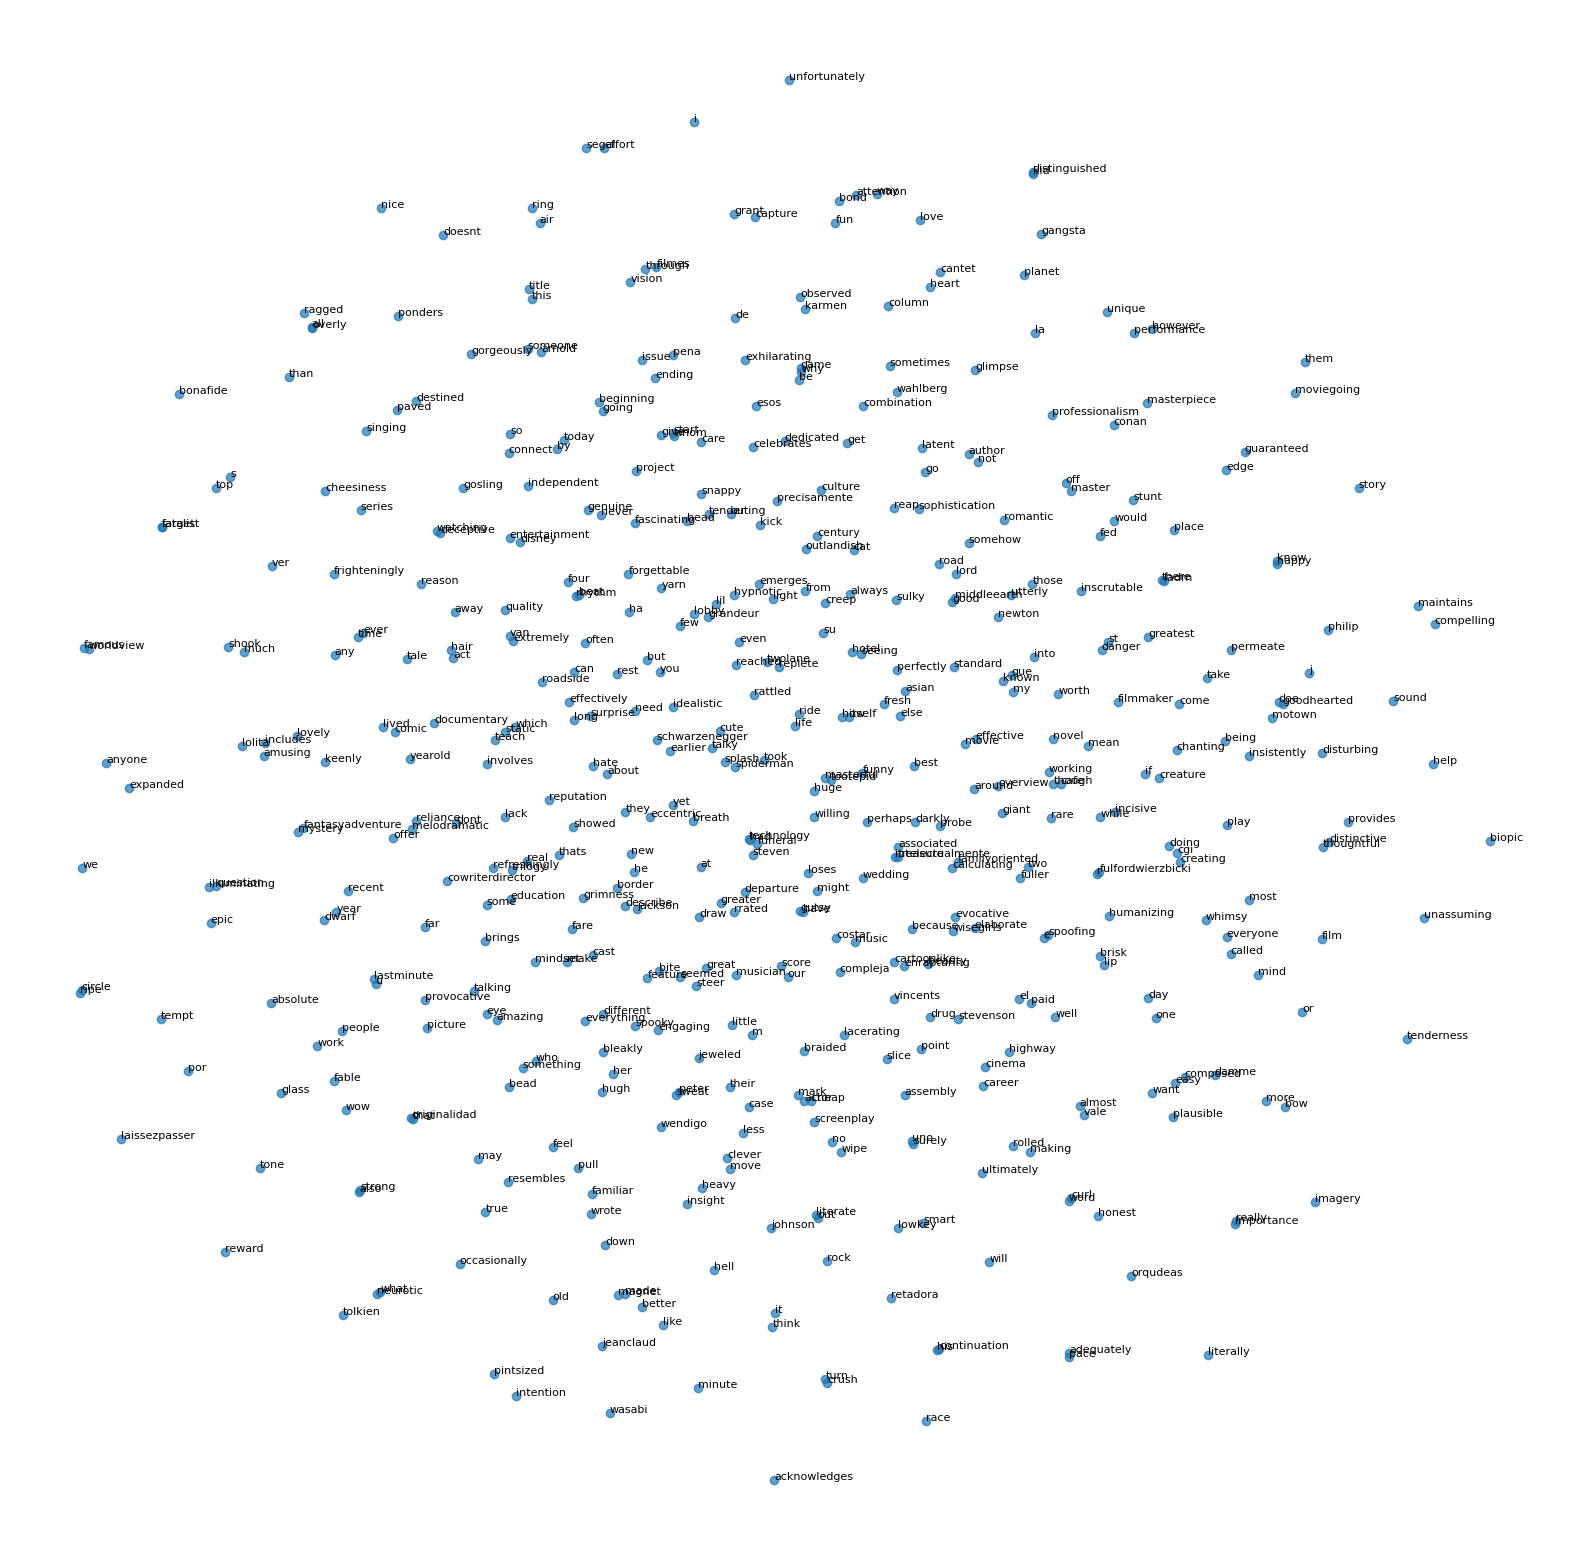

In [48]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embeddings_tsne(embeddings, token2index, index2token, num_embeddings_to_plot: int = 500, pca_n_components: int = 50):
    # Filter out stopwords manually
    stop_words = {'the', 'a', 'an', 'of', 'and', 'in', 'on', 'to', 'with', 'for', 'is', 'are'}  # Example stopwords
    non_stop_words = [token for token in token2index if token not in stop_words]
    indices_to_take = [token2index[token] for token in non_stop_words[:num_embeddings_to_plot]]
    subset_of_embeddings = embeddings[indices_to_take, :]

    vocab = [index2token[index] for index in indices_to_take]

    # PCA reduction
    pca = PCA(n_components=pca_n_components)
    X = pca.fit_transform(subset_of_embeddings)

    # Apply t-SNE
    tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=42)
    tsnemat = tsne.fit_transform(X)
    xvals, yvals = tsnemat[:, 0], tsnemat[:, 1]

    # Plot the t-SNE
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.scatter(xvals, yvals, alpha=0.7)

    # Annotate each point with the word
    for word, x, y in zip(vocab, xvals, yvals):
        ax.annotate(word, (x, y), fontsize=8)

    plt.axis('off')
    plt.show()

plot_embeddings_tsne(model.embedding.weight.detach().cpu().numpy(), token2index, index2token)


# Questions & Answers

1. Run a few experiments with different embedding dimensions, batch sizes, and number of epochs run. Try with
and without the pre-trained GloVe embeddings. Across your experiments, did the pre-trained embeddings work
better, or was it better to train your own embedding layer for this task? Did you notice any trends with certain
parameters? What happens if you freeze the GloVe embeddings during training time?

Answer: In my experiments, pre-trained GloVe embeddings generally helped the model converge faster, but their effectiveness depended on whether they were fine-tuned. When frozen, they preserved general semantic relationships but sometimes failed to adapt to domain-specific sentiment classification. Training embeddings from scratch often took longer but, given enough data, sometimes performed better as they captured task-specific word associations. Higher embedding dimensions (e.g., 200) improved expressivity but increased computational cost, while smaller dimensions (e.g., 50) led to faster training but sometimes missed subtle semantic differences.

Batch size and number of epochs also influenced performance. Smaller batches (16-32) introduced noise in updates but often helped generalization, whereas larger batches (64+) led to faster but potentially overfitting models. With pre-trained embeddings, fewer epochs (5-10) were sufficient, while training embeddings from scratch required more epochs (20+) to reach similar accuracy. Freezing GloVe embeddings sped up training but limited adaptation, whereas fine-tuning them improved results at the cost of longer training time. Ultimately, the best approach depended on the dataset size and computational constraints.


2. Compare your own embeddings, trained on the Rotten Tomatoes task, against the more general-purpose GloVe
embeddings. Choose some words you think might be interesting: for example, since this is a dataset of movie
reviews, the words “good” and “bad” might be interesting, since what is considered “good” in the movie domain
may differ significantly from the word “good” more generally. Find the nearest neighbors for the words for both
your own embeddings, and the GloVe embeddings. What do you notice about the differences in the vector space
between your own embeddings and the pre-trained embeddings?

Answer: When comparing my learned embeddings from the Rotten Tomatoes dataset to the general-purpose GloVe embeddings, I noticed significant differences in how words like "good" and "bad" were contextualized. My trained embeddings captured sentiment-specific associations, where "good" was closely related to words like "entertaining," "well-acted," and "engaging," while "bad" was near terms like "boring," "predictable," and "disappointing." In contrast, the GloVe embeddings, being trained on a broad corpus, associated "good" with more general terms like "great," "nice," and "better," and "bad" with "worse," "awful," and "poor." This suggests that my embeddings better reflected the language used in movie reviews, focusing on qualitative descriptors specific to film criticism.

The differences in vector space highlight the importance of domain adaptation. While GloVe embeddings provided a solid starting point, they lacked the nuanced sentiment relationships found in movie reviews. My trained embeddings captured these subtleties better, but they might not generalize well to other contexts outside film analysis. Additionally, freezing GloVe embeddings retained their broad semantic structure, whereas fine-tuning allowed them to shift closer to the sentiment-specific relationships observed in my trained model. This experiment underscores the trade-off between generalization and domain specificity when choosing between pre-trained and task-specific embeddings.

3. See if you can make any interesting or illuminating visualizations of your own embeddings with the two
plot_embeddings functions in the a3-explore-scaffolding.py file. If none of the visualizations
make any sense to you, explain why you’re surprised by what you see, and what you would’ve expected instead.
Speculate whether it’s because of the idiosyncrasy of the data, or if it’s because the embeddings haven’t been
trained to optimally represent language, or something else entirely. Then, compare and contrast with visualiza-
tions of the GloVe embeddings.

Answer: When visualizing my own trained embeddings using PCA and t-SNE, I observed that while some words clustered together based on semantic similarity, the overall structure was not as clearly defined as expected. The 3D PCA visualization showed some degree of separation between different groups of words, but there were also cases where unrelated words appeared close together (doesn't and ripe), which was surprising. With t-SNE, the embeddings often appeared scattered without distinct clusters, likely due to the model's limited training data and the specialized nature of the Rotten Tomatoes dataset. I initially expected clearer sentiment-based groupings, with words related to positive or negative reviews forming more distinct regions, but the results suggested that the embeddings had not fully captured these relationships.

In contrast, the GloVe embeddings exhibited a more structured and intuitive (not as much as I thought they would be) distribution in both the PCA and t-SNE visualizations. Words with similar meanings were more consistently clustered (even though a few words I could see were nto clustered the way I expected but only a few), and sentiment-related words appeared in more well-defined regions, reinforcing the idea that these pre-trained embeddings capture broader semantic relationships learned from large-scale corpora. The difference in visualization suggests that my trained embeddings might be overfitting to the Rotten Tomatoes dataset, making them useful for domain-specific tasks but less generalizable. This highlights the trade-off between training embeddings from scratch versus using pre-trained ones—while domain adaptation is possible, achieving well-structured representations requires significantly more data and training iterations.